In [1]:
from properties import POSTGRES_CREDENTIALS
from utils import create_connection
import pandas as pd

In [2]:
conn, cursor = create_connection("genius_db")
cursor.execute("select song_id, cluster_id from cluster")
clusters = pd.DataFrame(cursor.fetchall(), columns =["song_id", "cluster_id"])
conn.close()

In [ ]:
conn, cursor = create_connection("lfm2b")

# Create a forwarder to the genius DB so that we can easily join tables.
script = f"""
CREATE EXTENSION IF NOT EXISTS postgres_fdw;

DO $$
BEGIN
  IF NOT EXISTS (
    SELECT 1 FROM pg_foreign_server WHERE srvname = 'genius_server'
  ) THEN
    CREATE SERVER genius_server
      FOREIGN DATA WRAPPER postgres_fdw
      OPTIONS (host '{POSTGRES_CREDENTIALS["host"]}', dbname 'genius_db', port '{POSTGRES_CREDENTIALS["port"]}');
  END IF;
END
$$;

DO $$
BEGIN
  IF NOT EXISTS (
    SELECT 1 FROM pg_user_mappings
    WHERE srvname = 'genius_server'
    AND umuser = (SELECT usesysid FROM pg_user WHERE usename = 'postgres')
  ) THEN
    CREATE USER MAPPING FOR postgres
      SERVER genius_server
      OPTIONS (user '{POSTGRES_CREDENTIALS["user"]}', password '{POSTGRES_CREDENTIALS["password"]}');
  END IF;
END
$$;

DO $$
BEGIN
  IF NOT EXISTS (
    SELECT 1 FROM information_schema.tables
    WHERE table_schema = 'public' AND table_name = 'lfm2b_genius'
  ) THEN
    IMPORT FOREIGN SCHEMA public
      LIMIT TO (lfm2b_genius)
      FROM SERVER genius_server
      INTO public;
  END IF;
END
$$;
"""


cursor.execute(script)
cursor.execute("select  lg.song_id, le.user_id, le.track_id, le.age_at_listen, le.artist_id from listening_event le join lfm2b_genius lg using(track_id)")
data = pd.DataFrame(cursor.fetchall(), columns=["song_id", "user_id", "track_id", "age_at_listen", "artist_id"])
conn.close()

# Should take about 7 minutes

In [4]:
listening_events_with_clusters = data.merge(clusters, on="song_id")

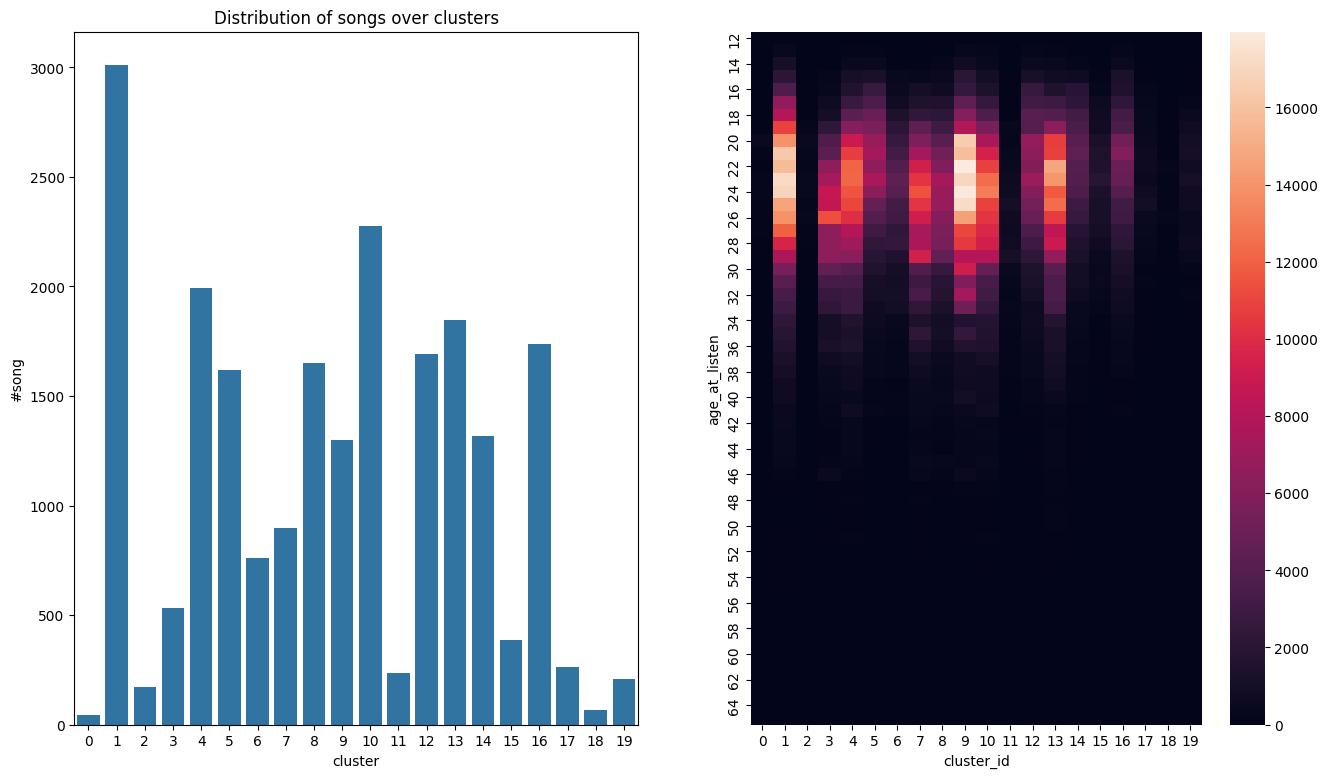

In [180]:
# Let's create a pivot table to see the amount of listening events per age_group and cluster
# https://www.statology.org/pandas-pivot-table-count/
pt = pd.pivot_table(listening_events_with_clusters, values="track_id", index="age_at_listen", columns="cluster_id", aggfunc="count") \
        .fillna(0) \
        .astype(int)

songs_per_cluster = clusters.groupby("cluster_id").count().reset_index()

import matplotlib.pyplot as plt
import seaborn as sns
fig, (ax1, ax2) = plt.subplots(figsize=(16,9), nrows=1, ncols=2)

ax1.set_title("Distribution of songs over clusters")
ax1.set_ylabel("#song")
ax1.set_xlabel("cluster")
sns.barplot(songs_per_cluster, x="cluster_id", y="song_id", ax=ax1)
sns.heatmap(pt, ax=ax2)
plt.show()

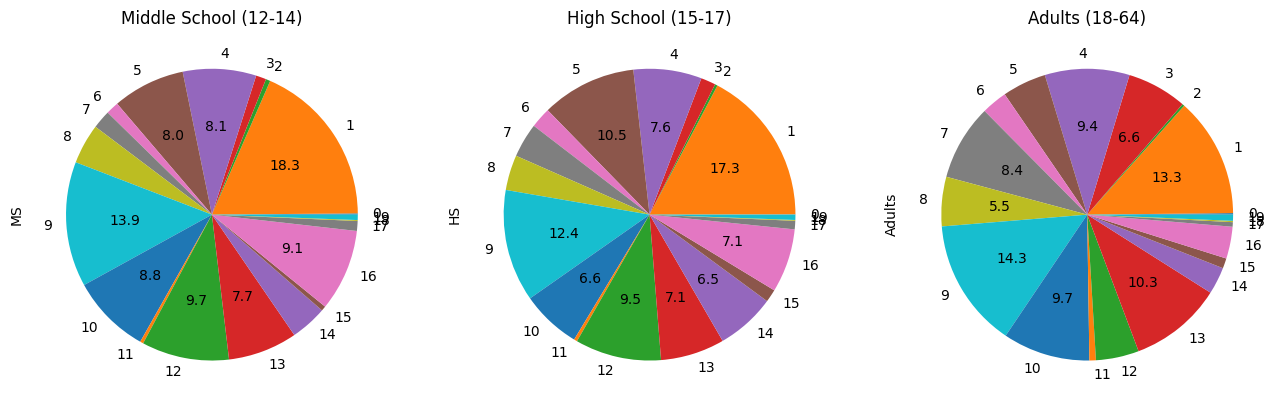

In [181]:
middle_school = pt.loc[12:14].sum()
middle_school.name = "MS"
high_school = pt.loc[15:17].sum()
high_school.name = "HS"
adults = pt.loc[18:].sum()
adults.name="Adults"
children = pt.loc[12:17].sum()
children.name="Children"


fig, (ax1, ax2, ax3) = plt.subplots(figsize = (16,9), ncols=3)

# https://stackoverflow.com/questions/63704956/pie-chart-show-percentage-of-specific-values#63705426 
show_percentages_more_than_5_perc = lambda val : ('%.1f' % val) if val > 5 else ''

middle_school.plot.pie(ax=ax1, title="Middle School (12-14)",autopct=show_percentages_more_than_5_perc)
high_school.plot.pie(ax=ax2, title="High School (15-17)", autopct=show_percentages_more_than_5_perc)
adults.plot.pie(ax=ax3, title="Adults (18-64)", autopct=show_percentages_more_than_5_perc)
plt.show()

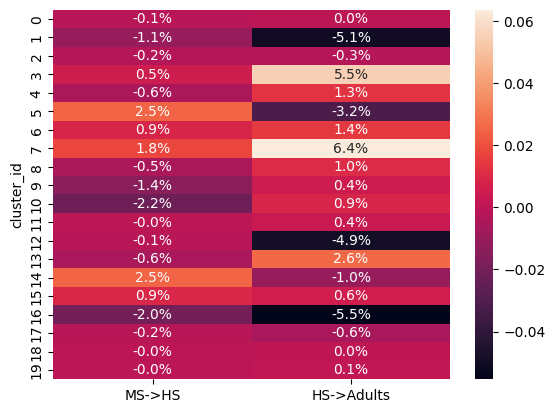

In [182]:
# Let's inspect the percentage point differences per cluster
le_counts_grouped = pd.concat([children, middle_school, high_school, adults], axis=1)
le_counts_grouped_normalized = le_counts_grouped.div(le_counts_grouped.sum(axis=0))


differences = pd.DataFrame(
    [
        le_counts_grouped_normalized["HS"] - le_counts_grouped_normalized["MS"],
        le_counts_grouped_normalized["Adults"] - le_counts_grouped_normalized["MS"],
    ],
    index=["MS->HS", "HS->Adults"]
).T
sns.heatmap(differences, annot=True, fmt=".1%")
plt.title("")
plt.show()

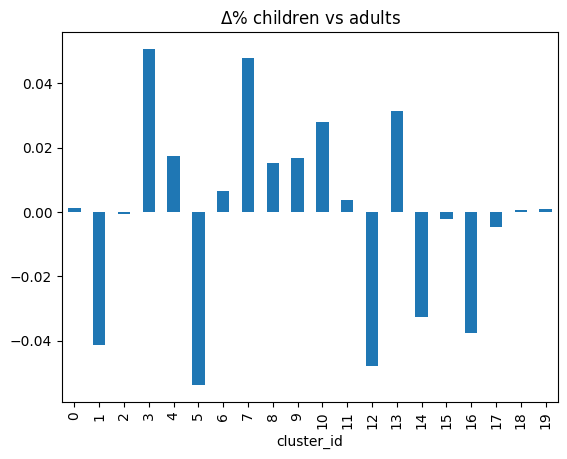

In [183]:
# What about significance of results?

(le_counts_grouped_normalized["Adults"] - le_counts_grouped_normalized["Children"]).plot.bar(title="$\Delta\%$ children vs adults")
plt.show()

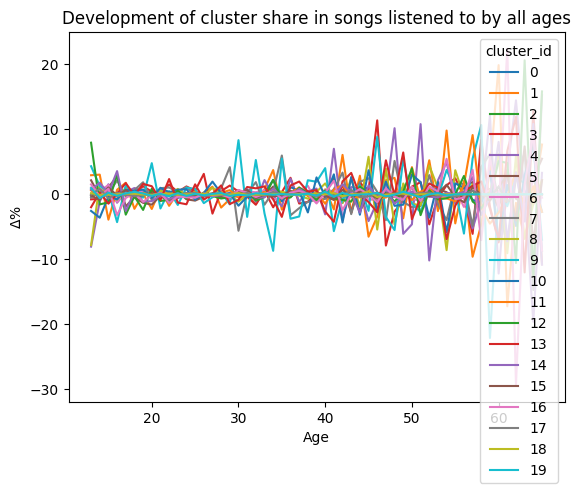

In [184]:
pt_normalized = pt.div(pt.sum(axis=1), axis=0)
(pt_normalized.diff() * 100).plot.line(title="Development of cluster share in songs listened to by all ages", xlabel="Age", ylabel="$\Delta\%$")
plt.show()